## parameters:

In [7]:
#= DOMAIN 
Lx = 10.0
Ly = 10.0
Nx = 100
Ny = 100
n_agents = 400
dt = 0.02

#= PHYSICS 
D = 0.06          # diffusion
gamma = 0.12      # decay
threshold = 0.45  # activation threshold
chi = 1.8         # chemotactic strength
D_eff = 0.015     # random motility

#= Initial injury (Gaussian)
initial_amplitude = 5.0
initial_width = 2.0

## Simulation

In [8]:
class MicrogliaSimulation:
    def __init__(self, sigma=3.0, seed=42):
        np.random.seed(seed)
        self.dx = Lx / Nx
        self.dt = dt
        self.sigma = sigma

        # Grid (Ny, Nx) to match imshow convention
        self.c = np.zeros((Ny, Nx))
        self.pos = np.random.rand(n_agents, 2) * [Lx, Ly]
        self.active = np.zeros(n_agents, dtype=bool)

        # Initial central injury
        yy, xx = np.indices((Ny, Nx))
        dist = np.sqrt((xx - Nx//2)**2 + (yy - Ny//2)**2)
        self.c = initial_amplitude * np.exp(-dist**2 / (2 * initial_width**2))

    def update(self):
        # PDE
        lap = (np.roll(self.c, 1, 0) + np.roll(self.c, -1, 0) +
               np.roll(self.c, 1, 1) + np.roll(self.c, -1, 1) - 4 * self.c) / self.dx**2

        source = np.zeros_like(self.c)
        if np.any(self.active):
            ix = (self.pos[self.active, 0] / self.dx).astype(int) % Nx
            iy = (self.pos[self.active, 1] / self.dx).astype(int) % Ny
            np.add.at(source, (iy, ix), self.sigma)

        self.c += self.dt * (D * lap - gamma * self.c + source)

        # Agents
        ix_all = (self.pos[:, 0] / self.dx).astype(int) % Nx
        iy_all = (self.pos[:, 1] / self.dx).astype(int) % Ny

        self.active = np.logical_or(self.active, self.c[iy_all, ix_all] > threshold)

        gy, gx = np.gradient(self.c, self.dx)
        grad = np.stack([gx[iy_all, ix_all], gy[iy_all, ix_all]], axis=1)
        norm = np.linalg.norm(grad, axis=1, keepdims=True) + 1e-9

        drift = chi * grad / norm
        drift[self.c[iy_all, ix_all] < 0.05] = 0   # flat signal → no drift

        noise = np.sqrt(2 * D_eff * self.dt) * np.random.randn(*self.pos.shape)
        self.pos += self.dt * drift + noise
        self.pos[:, 0] %= Lx
        self.pos[:, 1] %= Ly

        return self.c.copy(), self.pos.copy(), self.active.copy()

## Utils:

In [9]:
def compute_radial_profile(c):
    y, x = np.indices(c.shape)
    center = np.array(c.shape) // 2
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(int)
    tbin = np.bincount(r.ravel(), c.ravel())
    nr = np.bincount(r.ravel())
    return tbin / np.maximum(nr, 1)

def run_one_simulation(sigma, steps=1000, collect_every=20, seed=42):
    sim = MicrogliaSimulation(sigma=sigma, seed=seed)
    active_history = []
    radial_history = []
    times = []

    for step in range(steps):
        c, pos, active = sim.update()
        active_history.append(np.sum(active))
        times.append(step * sim.dt)

        if step % collect_every == 0 or step == steps - 1:
            radial_history.append(compute_radial_profile(c))

    return {
        'time': np.array(times),
        'active': np.array(active_history),
        'radial': radial_history,
        'final_c': c,
        'final_pos': pos,
        'final_active': active
    }

## run

Running σ = 0.0 ...
Running σ = 0.5 ...
Running σ = 3.0 ...


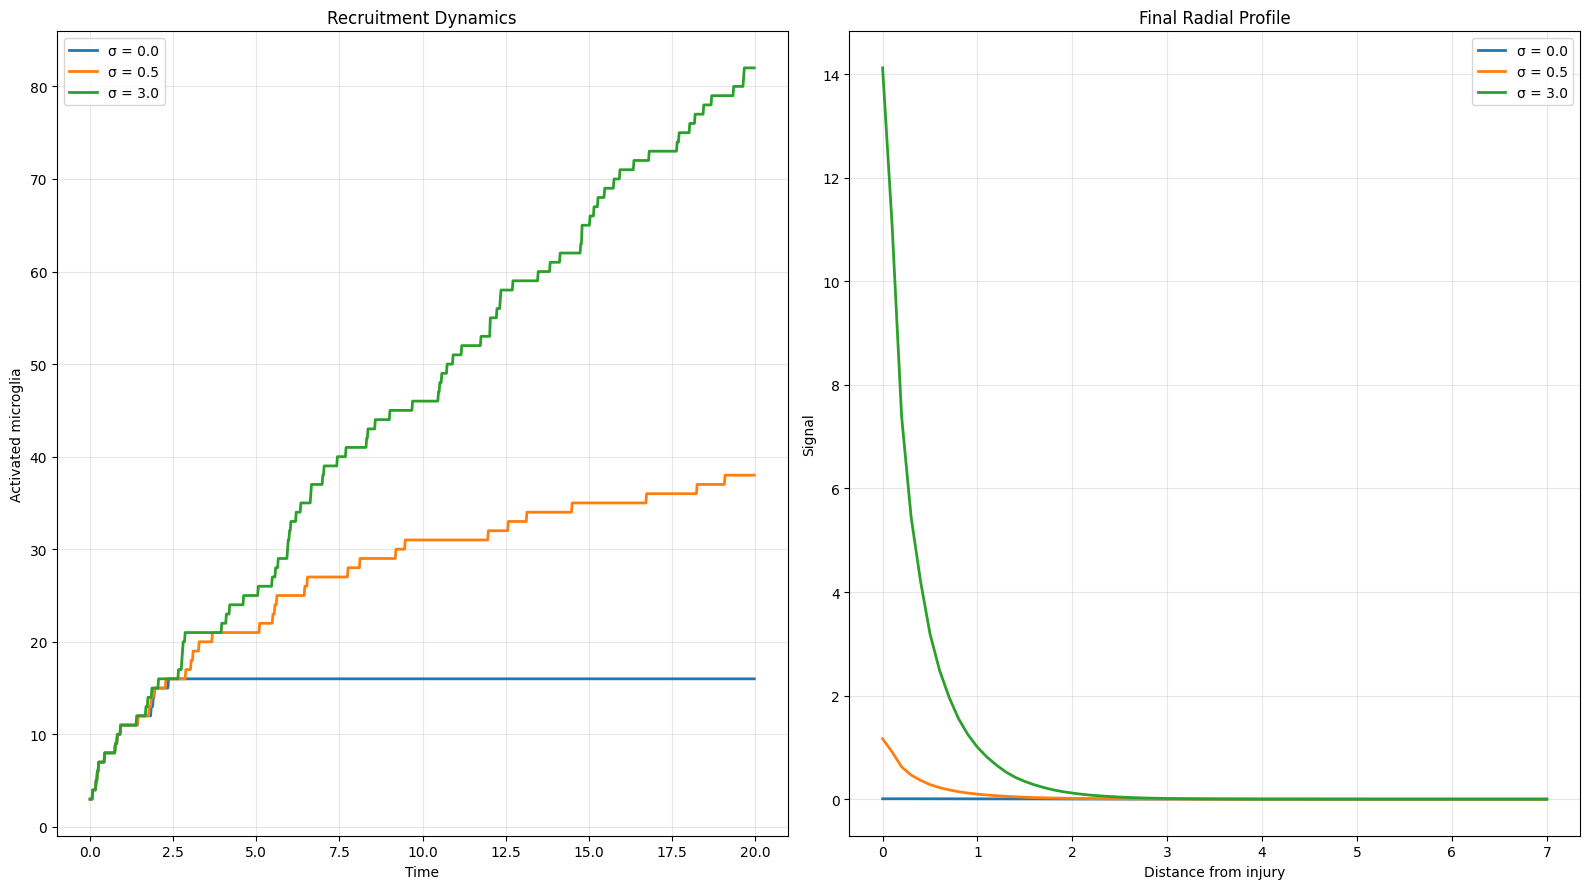

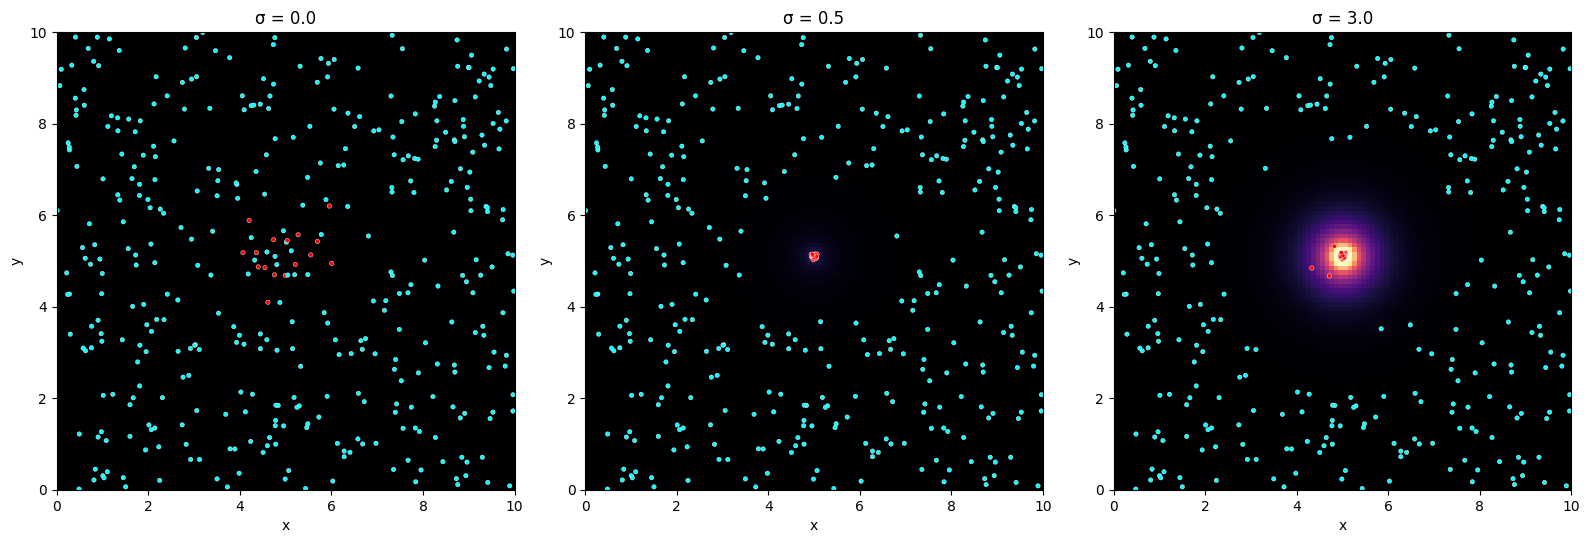

In [15]:
import numpy as np
import matplotlib.pyplot as plt

sigmas = [0.0, 0.5, 3.0]          # ← change this list whenever you want
labels = [f"σ = {s}" for s in sigmas]

results = {}
for s in sigmas:
    print(f"Running σ = {s} ...")
    results[s] = run_one_simulation(s, steps=1000)

#= PHASE DIAGRAM
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

# Recruitment curves
for s, lab in zip(sigmas, labels):
    axs[0].plot(results[s]['time'], results[s]['active'], label=lab, lw=2)
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Activated microglia")
axs[0].set_title("Recruitment Dynamics")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Final radial profiles
r = np.arange(results[sigmas[0]]['radial'][-1].shape[0]) * (Lx / Nx)
for s, lab in zip(sigmas, labels):
    axs[1].plot(r, results[s]['radial'][-1], label=lab, lw=2)
axs[1].set_xlabel("Distance from injury")
axs[1].set_ylabel("Signal")
axs[1].set_title("Final Radial Profile")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/signal_activity.pdf", dpi=300, bbox_inches='tight')
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(16, 9))

# Final snapshots (3 columns)
for i, s in enumerate(sigmas):
    ax = axs[i]
    c = results[s]['final_c']
    pos = results[s]['final_pos']
    active = results[s]['final_active']
    ax.imshow(c, origin='lower', extent=[0, Lx, 0, Ly], cmap='magma', vmax=8)
    colors = np.where(active, 'red', 'cyan')
    ax.scatter(pos[:,0], pos[:,1], c=colors, s=10, edgecolors='white', linewidth=0.3)
    ax.set_title(labels[i])
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.savefig("../figures/radial_diagram.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Video generator

In [21]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

def generate_video(steps=600, sigma=4.0, n_agents=n_agents, filename= "../figures/microglia_final_result.mp4"):
    sim = MicrogliaSimulation(sigma=sigma, seed=42)
    sim.pos = np.random.rand(n_agents, 2) * [Lx, Ly]   # override if you want more agents

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im = ax1.imshow(sim.c, origin='lower', extent=[0, Lx, 0, Ly], cmap='magma', vmax=10)
    scat = ax1.scatter(sim.pos[:,0], sim.pos[:,1], s=8, c='cyan')
    ax1.set_title("Signal + Cells")

    line, = ax2.plot([], [], 'r-', lw=2)
    ax2.set_xlim(0, steps * dt)
    ax2.set_ylim(0, n_agents)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Active cells")

    def update(frame):
        c, pos, active = sim.update()
        im.set_array(c)
        scat.set_offsets(pos)
        scat.set_color(['red' if a else 'cyan' for a in active])

        times = np.arange(frame+1) * dt
        counts = [np.sum(sim.active)]   # dummy – in real code you'd collect history
        # (for simplicity we just show current count; improve later if needed)
        line.set_data(times, [np.sum(active)] * (frame+1))

        return im, scat, line

    ani = FuncAnimation(fig, update, frames=steps, interval=20, blit=False)
    writer = FFMpegWriter(fps=30, bitrate=2000)
    ani.save(filename, writer=writer)
    plt.close()
    print(f"Video saved as {filename}")

generate_video(sigma=3.0, filename="../figures/microglia_final_result.mp4")

Video saved as ../figures/microglia_final_result.mp4
